In [2]:
!pip install xmltodict node2vec

In [3]:

import tensorflow as tf
import networkx as nx
import numpy as np
import keras
from keras.layers import Dense
from keras.optimizers import Adam
import xmltodict
import pandas as pd
import networkx as nx
import math
import random
import matplotlib.pyplot as plt
from collections import Counter
from queue import PriorityQueue
import csv
from datetime import datetime
import pytz
import os
from node2vec import Node2Vec

np.random.seed(42)
num_actions=8

2024-02-26 15:05:50.474348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 15:05:50.474507: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 15:05:50.586684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:


class PolicyNetwork(tf.keras.Model):
    def __init__(self, num_actions,learning_rate=0.001, seed=None):
        super(PolicyNetwork, self).__init__()
        self.initializer = keras.initializers.GlorotUniform(seed=seed)
        self.dense1 =Dense(512, activation='relu',kernel_initializer=self.initializer)
        self.dense2 =Dense(1024, activation='relu',kernel_initializer=self.initializer)
        self.output_layer =Dense(num_actions, activation='softmax',kernel_initializer=self.initializer)
        self.optimizer = Adam(learning_rate=learning_rate)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)

    def update(self, state, action):
        with tf.GradientTape() as tape:
            action_prob = self(state)
            #print('action type in model: ',type(action),action)
            action_mask = tf.one_hot(action, depth=num_actions)
            picked_action_prob = tf.reduce_sum(action_prob * action_mask, axis=1)
            loss = tf.reduce_sum(-tf.math.log(picked_action_prob ))+sum(tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.REGULARIZATION_LOSSES))
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss
    def reinforce_update(self, states, actions, rewards, next_states, gamma=0.99):
        with tf.GradientTape() as tape:
            loss = 0
            for state, action, reward, next_state in zip(states, actions, rewards, next_states):
                current_state_value = self(state)  # Get the predicted value of the current state
                next_state_value = self(next_state)  # Get the predicted value of the next state

                # Compute the TD target using the immediate reward and the value of the next state
                td_target = reward + gamma * tf.reduce_max(next_state_value)

                # Compute the advantage by subtracting the current state value from the TD target
                advantage = td_target - tf.reduce_sum(current_state_value * tf.one_hot(action, depth=num_actions), axis=1)

                # Compute the loss as the negative log probability of the taken action, scaled by the computed advantage
                action_probs = tf.reduce_sum(current_state_value * tf.one_hot(action, depth=num_actions), axis=1)
                loss += tf.reduce_mean(-tf.math.log(action_probs + 1e-6) * advantage)

        # Compute gradients and update network weights
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

    def predict(self, state):
        action_prob = self(state, training=False)
        return action_prob.numpy()


def calculate_initial_compass_bearing(pointA, pointB):
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing



def id_angle(angle):
    if angle <= 22.5 or angle > 337.5:
        return 0
    elif angle > 22.5 and angle <= 67.5:
        return 1
    elif angle > 67.5 and angle <= 112.5:
        return 2
    elif angle > 112.5 and angle <= 157.5:
        return 3
    elif angle > 157.5 and angle <= 202.5:
        return 4
    elif angle > 202.5 and angle <= 247.5:
        return 5
    elif angle > 247.5 and angle <= 292.5:
        return 6
    elif angle > 292.5 and angle <= 337.5:
        return 7



def calculate_combined_reward(aqi, green, noise,distance):
    a=b=c=0
    if aqi >=7:
        a = 100
    elif aqi >=4:
        a = 60
    elif aqi >=0.0:
        a = 30
    if green >=7:
        b = 100
    elif green >=4:
        b = 60
    elif green >=0.0:
        b = 30
    if noise >=7:
        c = 100
    elif noise >=4:
        c = 60
    elif noise >=0.0:
        c = 30
    return (math.log(a)*aqi + math.log(b)*green + math.log(c)*noise) / distance


def get_next_state(graph,node,action_chosen):
    next_chosen_node=None
    next_nn = list(graph.neighbors(node))
    actions=[]
    for n in  next_nn:
        action=id_angle(calculate_initial_compass_bearing((G.nodes[node]['latitude'],G.nodes[node]['longitude']),(G.nodes[n]['latitude'],G.nodes[n]['longitude'])))
        if(action==action_chosen):
            actions.append(n)
    print('len of same action: ',len(actions))
    next_chosen_node=random.choice(actions)
    green=graph[node][next_chosen_node]['green_view_index']
    aqi=graph[node][next_chosen_node]['aqi']
    len=graph[node][next_chosen_node]['distance']
    noise=graph[node][next_chosen_node]['noise']
    return next_chosen_node,green,aqi,noise,len



def state_embedding(state_idx,embed):
    curr=embed[state_idx[0]]
    targ=embed[state_idx[1]]
    state=np.expand_dims(np.concatenate((np.asarray(curr), np.asarray(targ) - np.asarray(curr))), axis=0)
    return state

def remove_cycles(path):
    rel_ents=path
    entity_stats = Counter(path).items()
    duplicate_ents = [item for item in entity_stats if item[1] != 1]
    duplicate_ents.sort(key=lambda t: t[1], reverse=True)
    for item in duplicate_ents:
        ent = item[0]
        ent_idx = [i for i, x in enumerate(rel_ents) if x == ent]
        if len(ent_idx) != 0:
            min_idx = min(ent_idx)
            max_idx = max(ent_idx)
            if min_idx != max_idx:
                rel_ents = rel_ents[:min_idx] + rel_ents[max_idx:]
    return rel_ents


def random_path(G,source,target):
    paths=nx.all_simple_paths(G,source,target,cutoff=10)
    return random.choice(list(paths))



# Function to create a connected graph
def create_connected_graph(num_nodes, num_edges):
    G = nx.Graph()

    # Add nodes with latitude and longitude
    for i in range(num_nodes):
        G.add_node(i, latitude=random.uniform(-90, 90), longitude=random.uniform(-180, 180))

    # Ensure the graph is connected by adding edges to form a spanning tree
    nodes = list(G.nodes)
    random.shuffle(nodes)
    for i in range(num_nodes - 1):
        G.add_edge(nodes[i], nodes[i + 1],
                   distance=random.uniform(5, 15),
                   aqi=random.randint(1, 10),
                   green_view_index=random.randint(1, 10),
                   noise=random.randint(1, 10))

    # Add additional edges to reach the desired count, ensuring no duplicates
    while G.number_of_edges() < num_edges:
        n1, n2 = random.sample(list(G.nodes), 2)
        if not G.has_edge(n1, n2):
            G.add_edge(n1, n2,
                       distance=random.uniform(5, 15),
                       aqi=random.randint(1, 10),
                       green_view_index=random.randint(1, 10),
                       noise=random.randint(1, 10))

    return G

# Create the graph
num_nodes = 50
num_edges = 90
G = create_connected_graph(num_nodes, num_edges)
# for (u, v, attribs) in G.edges(data=True):
#     print(f"Edge ({u}, {v}) has attributes: {attribs}")

In [5]:
dimensions = 128  # Dimensionality of the embeddings
walk_length = 30  # Maximum length of a random walk
num_walks = 200  # Number of walks per node
workers = 4  # Number of workers for parallel execution

# Create a Node2Vec model
node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)

# Fit the model to generate the embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embeddings for all nodes in the graph
node_embeddings = {node: model.wv[str(node)] for node in G.nodes()}

Computing transition probabilities:   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 61.16it/s]


In [6]:
import itertools
from sklearn.model_selection import train_test_split
def generate_node_pairs(graph):
    nodes = list(graph.nodes)
    return list(itertools.permutations(nodes, 2))
all_pairs = generate_node_pairs(G)

# Shuffle the pairs to randomize the order
random.shuffle(all_pairs)

# Split the pairs into training and testing sets (80% training, 20% testing)
train_pairs, test_pairs = train_test_split(all_pairs, test_size=0.2, random_state=42)
print(len(train_pairs),len(test_pairs))

1960 490


In [7]:
def create_modified_graph(original_graph):
    modified_graph = original_graph.copy()
    for edge in modified_graph.edges(data=True):
        # Modify AQI attribute
        edge[2]['aqi'] = 10 - edge[2]['aqi'] + 1
        # Modify noise attribute
        edge[2]['noise'] = 10 - edge[2]['noise'] + 1
        # Modify green view index attribute
        edge[2]['green_view_index'] = 10 - edge[2]['green_view_index'] + 1
    return modified_graph

# Create the modified graph
modified_G = create_modified_graph(G)

In [8]:
import matplotlib.pyplot as plt

policy_network = PolicyNetwork(num_actions,seed=42)
failure=0
r_cn=0
g_cn=0

def choose_action_with_epsilon_greedy(action_probs, available_actions, epsilon):
    global r_cn, g_cn
    if np.random.rand() < epsilon:  # With probability epsilon, choose a random action
        r_cn += 1
        return np.random.choice(available_actions)
    else:
        g_cn += 1
        # Set the probabilities of unavailable actions to 0
        adjusted_probs = np.zeros_like(action_probs)
        for action_index in available_actions:
            if action_index < len(action_probs):
                adjusted_probs[action_index] = action_probs[action_index]

        # Normalize the probabilities of available actions to sum to 1
        if adjusted_probs.sum() > 0:
            adjusted_probs /= adjusted_probs.sum()
        else:
            # If all adjusted_probs are 0 (unlikely but possible), treat it as a random choice among available actions
            return np.random.choice(available_actions)

        # Use np.random.choice to select an action based on the adjusted probabilities
        return np.random.choice(len(action_probs), p=adjusted_probs)


def dfs_path_epsilon_greedy(graph, source, destination, epsilon, max_allowed_length, path=None, visited=None, total_distance=0):
    if path is None:
        path = [source]
    if visited is None:
        visited = set()

    visited.add(source)

    if source == destination:
        return path

    neighbors = list(graph.neighbors(source))
    action_neighbor_mapping = {}
    available_actions = []
    for neighbor in neighbors:
        if neighbor not in visited:
            a = id_angle(calculate_initial_compass_bearing((G.nodes[source]['latitude'], G.nodes[source]['longitude']), (G.nodes[neighbor]['latitude'], G.nodes[neighbor]['longitude'])))
            available_actions.append(a)
            action_neighbor_mapping[a] = neighbor

    while available_actions:
        # Assuming action_probs are uniform as no model output is provided. Modify as needed.
        cur_state = state_embedding([source, destination], node_embeddings)  # Assuming state_embedding function
        action_probs = policy_network.predict(cur_state)[0]

        # Select an action (neighbor) using the epsilon-greedy strategy
        chosen_action = choose_action_with_epsilon_greedy(action_probs, available_actions, epsilon)
        chosen_neighbor = action_neighbor_mapping[chosen_action]

        # Temporarily add the distance to check if it exceeds max_allowed_length
        temp_total_distance = total_distance + graph[source][chosen_neighbor]['distance']

        if temp_total_distance <= max_allowed_length:
            result_path= dfs_path_epsilon_greedy(graph, chosen_neighbor, destination, epsilon, max_allowed_length, path + [chosen_neighbor], visited, temp_total_distance)
            if result_path is not None:
                return result_path

        # Remove chosen_action from available_actions to avoid reselecting it
        available_actions.remove(chosen_action)

    visited.remove(source)  # Backtrack: remove the current source from visited to allow revisiting it through a different path
    return None  # No path found from any neighbor within max_allowed_length



def run_pretrain(G):
    episode=0
    for pair in train_pairs:
        # if(testing==20):
        #     break
        episode+=1
        src,dest=pair
        dijkstra_path = nx.dijkstra_path(G,src,dest,weight='distance')
        # dijkstra_path=remove_cycles(dijkstra_path)
        # actions,rewards_data = get_actions_from_shortest_path(G,dijkstra_path)
        for i in range(len(dijkstra_path)-1):
            curr=node_embeddings[dijkstra_path[i]]
            targ=node_embeddings[dest]
            state=np.expand_dims(np.concatenate((np.asarray(curr), np.asarray(targ) - np.asarray(curr))), axis=0)
            state= np.squeeze(state)
            state= np.reshape(state, [-1, 256])
            action=id_angle(calculate_initial_compass_bearing((G.nodes[dijkstra_path[i]]['latitude'], G.nodes[dijkstra_path[i]]['longitude']),(G.nodes[dijkstra_path[i+1]]['latitude'], G.nodes[dijkstra_path[i+1]]['longitude'])))
            policy_network.update(state,action)

        if(episode%10==0):
            print('epi done: ',episode)



def run_training_episodes(G,episodes=300):
    global failure
    model_aqi_means = []
    model_green_means = []
    model_noise_means = []
    model_avg_rewards = []
    model_cumulative_rewards = []

    shortest_aqi_means = []
    shortest_green_means = []
    shortest_noise_means = []
    shortest_avg_rewards = []
    shortest_cumulative_rewards = []

    shortest_aqi_path_aqi_means = []
    shortest_aqi_path_green_means = []
    shortest_aqi_path_noise_means = []
    shortest_aqi_path_avg_rewards = []
    shortest_aqi_path_cumulative_rewards = []

    shortest_green_path_aqi_means = []
    shortest_green_path_green_means = []
    shortest_green_path_noise_means = []
    shortest_green_path_avg_rewards = []
    shortest_green_path_cumulative_rewards = []

    shortest_noise_path_aqi_means = []
    shortest_noise_path_green_means = []
    shortest_noise_path_noise_means = []
    shortest_noise_path_avg_rewards = []
    shortest_noise_path_cumulative_rewards = []


    episode=0
    testing=0
    for pair in train_pairs:
        # if(testing==20):
        #     break
        source_node ,destination_node=pair
        episode+=1
        testing+=1
        print('source ,dest: for episode ',source_node,destination_node,episode)
        shortest_path_length = nx.shortest_path_length(G, source_node, destination_node, weight='distance')
        max_allowed_length = 2 * shortest_path_length
        path = dfs_path_epsilon_greedy(G, source_node, destination_node,.1,max_allowed_length)
        if(path==None):
            failure+=1
            continue

        states = []
        actions = []
        rewards = []
        next_states = []
        rl_aqi=[]
        rl_noise=[]
        rl_green=[]
        for i in range(len(path) - 1):
            state = state_embedding([path[i], destination_node], node_embeddings)
            action = id_angle(calculate_initial_compass_bearing(
                (G.nodes[path[i]]['latitude'], G.nodes[path[i]]['longitude']),
                (G.nodes[path[i + 1]]['latitude'], G.nodes[path[i + 1]]['longitude'])
            ))
            green=G[path[i]][path[i + 1]]['green_view_index']
            aqi=G[path[i]][path[i + 1]]['aqi']
            length=G[path[i]][path[i + 1]]['distance']
            noise=G[path[i]][path[i + 1]]['noise']
            rl_aqi.append(aqi)
            rl_noise.append(noise)
            rl_green.append(green)
            reward = calculate_combined_reward(aqi, green, noise, length)
            next_state = state_embedding([path[i + 1], destination_node], node_embeddings)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)

        policy_network.reinforce_update(states, actions, rewards, next_states)

        model_aqi_mean=np.mean(rl_aqi)
        model_green_mean=np.mean(rl_green)
        model_noise_mean=np.mean(rl_noise)
        model_avg_reward=np.mean(rewards)
        model_cumulative_reward=np.sum(rewards)

        # path = remove_cycles(path)
        print(f"Episode {episode + 1}: Path from {source_node} to {destination_node} - {path}")
        shortest_path = nx.shortest_path(G, source_node, destination_node, weight='distance')
        print("Shortest path to destination:", shortest_path)

        shortest_aqi=[]
        shortest_noise=[]
        shortest_green=[]
        rewards=[]

        for i in range(len(shortest_path) - 1):
            green=G[shortest_path[i]][shortest_path[i + 1]]['green_view_index']
            aqi=G[shortest_path[i]][shortest_path[i + 1]]['aqi']
            length=G[shortest_path[i]][shortest_path[i + 1]]['distance']
            noise=G[shortest_path[i]][shortest_path[i + 1]]['noise']
            shortest_aqi.append(aqi)
            shortest_noise.append(noise)
            shortest_green.append(green)
            reward = calculate_combined_reward(aqi, green, noise, length)
            rewards.append(reward)

            # Calculate metrics for the model's path


        shortest_aqi_mean=np.mean(shortest_aqi)
        shortest_green_mean=np.mean(shortest_green)
        shortest_noise_mean=np.mean(shortest_noise)
        shortest_avg_reward=np.mean(rewards)
        shortest_cumulative_reward=np.sum(rewards)

        # print('---------our model------')
        # print('aqi,green,noise,len,rewards: ',model_aqi_mean,model_green_mean,model_noise_mean,model_avg_reward,model_cumulative_reward,len(path))
        # print('----------------end-------')

        # print('---------shortest model------')
        # print('aqi,green,noise,len,rewards: ',shortest_aqi_mean,shortest_green_mean,shortest_noise_mean,shortest_avg_reward,shortest_cumulative_reward,len(shortest_path))
        # print('----------------end-------')

        # Store metrics for this episode
        model_aqi_means.append(model_aqi_mean)
        model_green_means.append(model_green_mean)
        model_noise_means.append(model_noise_mean)
        model_avg_rewards.append(model_avg_reward)
        model_cumulative_rewards.append(model_cumulative_reward)

        shortest_aqi_means.append(shortest_aqi_mean)
        shortest_green_means.append(shortest_green_mean)
        shortest_noise_means.append(shortest_noise_mean)
        shortest_avg_rewards.append(shortest_avg_reward)
        shortest_cumulative_rewards.append(shortest_cumulative_reward)


        shortest_path_aqi = nx.shortest_path(modified_G, source_node, destination_node, weight='aqi')
        shortest_path_noise = nx.shortest_path(modified_G, source_node, destination_node, weight='noise')
        shortest_path_green = nx.shortest_path(modified_G, source_node, destination_node, weight='green_view_index')

        shortest_aqi_path_a=[]
        shortest_aqi_path_n=[]
        shortest_aqi_path_g=[]
        rewards=[]

        for i in range(len(shortest_path_aqi) - 1):
            green=G[shortest_path_aqi[i]][shortest_path_aqi[i + 1]]['green_view_index']
            aqi=G[shortest_path_aqi[i]][shortest_path_aqi[i + 1]]['aqi']
            length=G[shortest_path_aqi[i]][shortest_path_aqi[i + 1]]['distance']
            noise=G[shortest_path_aqi[i]][shortest_path_aqi[i + 1]]['noise']
            shortest_aqi_path_a.append(aqi)
            shortest_aqi_path_n.append(noise)
            shortest_aqi_path_g.append(green)
            reward = calculate_combined_reward(aqi, green, noise, length)
            rewards.append(reward)

        shortest_aqi_path_aqi_means=np.mean(shortest_aqi_path_a)
        shortest_aqi_path_green_means=np.mean(shortest_aqi_path_g)
        shortest_aqi_path_noise_means=np.mean(shortest_aqi_path_n)
        shortest_aqi_path_avg_rewards=np.mean(rewards)
        shortest_aqi_path_cumulative_rewards=np.sum(rewards)

        shortest_noise_path_a=[]
        shortest_noise_path_n=[]
        shortest_noise_path_g=[]
        rewards=[]

        for i in range(len(shortest_path_noise) - 1):
            green=G[shortest_path_noise[i]][shortest_path_noise[i + 1]]['green_view_index']
            aqi=G[shortest_path_noise[i]][shortest_path_noise[i + 1]]['aqi']
            length=G[shortest_path_noise[i]][shortest_path_noise[i + 1]]['distance']
            noise=G[shortest_path_noise[i]][shortest_path_noise[i + 1]]['noise']
            shortest_noise_path_a.append(aqi)
            shortest_noise_path_n.append(noise)
            shortest_noise_path_g.append(green)
            reward = calculate_combined_reward(aqi, green, noise, length)
            rewards.append(reward)

        shortest_noise_path_am=np.mean(shortest_noise_path_a)
        shortest_noise_path_gm=np.mean(shortest_noise_path_g)
        shortest_noise_path_nm=np.mean(shortest_noise_path_n)
        shortest_noise_path_avg_r=np.mean(rewards)
        shortest_noise_path_cumulative_r=np.sum(rewards)

        shortest_noise_path_aqi_means.append(shortest_noise_path_am)
        shortest_noise_path_green_means.append(shortest_noise_path_gm)
        shortest_noise_path_noise_means.append(shortest_noise_path_nm)
        shortest_noise_path_avg_rewards.append(shortest_noise_path_avg_r)
        shortest_noise_path_cumulative_rewards.append(shortest_noise_path_cumulative_r)

        shortest_green_path_a=[]
        shortest_green_path_n=[]
        shortest_green_path_g=[]
        rewards=[]

        for i in range(len(shortest_path_green) - 1):
            green=G[shortest_path_green[i]][shortest_path_green[i + 1]]['green_view_index']
            aqi=G[shortest_path_green[i]][shortest_path_green[i + 1]]['aqi']
            length=G[shortest_path_green[i]][shortest_path_green[i + 1]]['distance']
            noise=G[shortest_path_green[i]][shortest_path_green[i + 1]]['noise']
            shortest_green_path_a.append(aqi)
            shortest_green_path_n.append(noise)
            shortest_green_path_g.append(green)
            reward = calculate_combined_reward(aqi, green, noise, length)
            rewards.append(reward)

        shortest_green_path_am=np.mean(shortest_green_path_a)
        shortest_green_path_gm=np.mean(shortest_green_path_g)
        shortest_green_path_nm=np.mean(shortest_green_path_n)
        shortest_green_path_avg_r=np.mean(rewards)
        shortest_green_path_cumulative_r=np.sum(rewards)

        shortest_green_path_aqi_means.append(shortest_green_path_am)
        shortest_green_path_green_means.append(shortest_green_path_gm)
        shortest_green_path_noise_means.append(shortest_green_path_nm)
        shortest_green_path_avg_rewards.append(shortest_green_path_avg_r)
        shortest_green_path_cumulative_rewards.append(shortest_green_path_cumulative_r)


    model_mean_values = {
        'aqi_mean': np.mean(model_aqi_means),
        'green_mean': np.mean(model_green_means),
        'noise_mean': np.mean(model_noise_means),
        'avg_reward': np.mean(model_avg_rewards),
        'cumulative_reward': np.sum(model_cumulative_rewards)
    }

    shortest_mean_values = {
        'aqi_mean': np.mean(shortest_aqi_means),
        'green_mean': np.mean(shortest_green_means),
        'noise_mean': np.mean(shortest_noise_means),
        'avg_reward': np.mean(shortest_avg_rewards),
        'cumulative_reward': np.sum(shortest_cumulative_rewards)
    }

    shortest_aqi_mean_values = {
        'aqi_mean': np.mean(shortest_aqi_path_aqi_means),
        'green_mean': np.mean(shortest_aqi_path_green_means),
        'noise_mean': np.mean(shortest_aqi_path_noise_means),
        'avg_reward': np.mean(shortest_aqi_path_avg_rewards),
        'cumulative_reward': np.sum(shortest_aqi_path_cumulative_rewards)
    }

    shortest_green_mean_values = {
        'aqi_mean': np.mean(shortest_green_path_aqi_means),
        'green_mean': np.mean(shortest_green_path_green_means),
        'noise_mean': np.mean(shortest_green_path_noise_means),
        'avg_reward': np.mean(shortest_green_path_avg_rewards),
        'cumulative_reward': np.sum(shortest_green_path_cumulative_rewards)
    }

    shortest_noise_mean_values = {
        'aqi_mean': np.mean(shortest_noise_path_aqi_means),
        'green_mean': np.mean(shortest_noise_path_green_means),
        'noise_mean': np.mean(shortest_noise_path_noise_means),
        'avg_reward': np.mean(shortest_noise_path_avg_rewards),
        'cumulative_reward': np.sum(shortest_noise_path_cumulative_rewards)
    }

    return model_mean_values, shortest_mean_values, shortest_aqi_mean_values, shortest_green_mean_values, shortest_noise_mean_values

# run_pretrain(G)




model_mean_values, shortest_mean_values, shortest_aqi_mean_values, shortest_green_mean_values, shortest_noise_mean_values=run_training_episodes(G)
print('fail:',failure,r_cn,g_cn)


epi done:  10
epi done:  20
epi done:  30
epi done:  40
epi done:  50
epi done:  60
epi done:  70
epi done:  80
epi done:  90
epi done:  100
epi done:  110
epi done:  120
epi done:  130
epi done:  140
epi done:  150
epi done:  160
epi done:  170
epi done:  180
epi done:  190
epi done:  200
epi done:  210
epi done:  220
epi done:  230
epi done:  240
epi done:  250
epi done:  260
epi done:  270
epi done:  280
epi done:  290
epi done:  300
epi done:  310
epi done:  320
epi done:  330
epi done:  340
epi done:  350
epi done:  360
epi done:  370
epi done:  380
epi done:  390
epi done:  400
epi done:  410
epi done:  420
epi done:  430
epi done:  440
epi done:  450
epi done:  460
epi done:  470
epi done:  480
epi done:  490
epi done:  500
epi done:  510
epi done:  520
epi done:  530
epi done:  540
epi done:  550
epi done:  560
epi done:  570
epi done:  580
epi done:  590
epi done:  600
epi done:  610
epi done:  620
epi done:  630
epi done:  640
epi done:  650
epi done:  660
epi done:  670
epi 

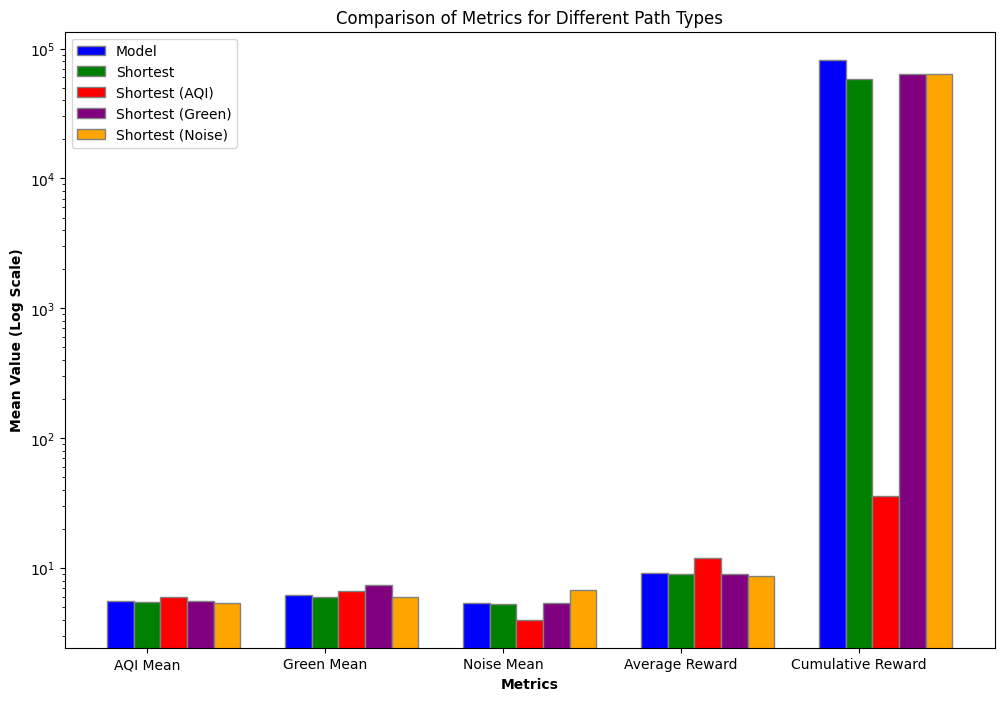

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics and corresponding labels
metrics = list(model_mean_values.keys())
metric_labels = ['AQI Mean', 'Green Mean', 'Noise Mean', 'Average Reward', 'Cumulative Reward']

# Extract the mean values for each metric and path type
model_values = list(model_mean_values.values())
shortest_values = list(shortest_mean_values.values())
shortest_aqi_values = list(shortest_aqi_mean_values.values())
shortest_green_values = list(shortest_green_mean_values.values())
shortest_noise_values = list(shortest_noise_mean_values.values())

# Set the width of the bars
bar_width = 0.15

# Set the positions of the bars on the x-axis
r1 = np.arange(len(metrics))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Plotting the bars
plt.figure(figsize=(12, 8))
plt.bar(r1, model_values, color='blue', width=bar_width, edgecolor='grey', label='Model')
plt.bar(r2, shortest_values, color='green', width=bar_width, edgecolor='grey', label='Shortest')
plt.bar(r3, shortest_aqi_values, color='red', width=bar_width, edgecolor='grey', label='Shortest (AQI)')
plt.bar(r4, shortest_green_values, color='purple', width=bar_width, edgecolor='grey', label='Shortest (Green)')
plt.bar(r5, shortest_noise_values, color='orange', width=bar_width, edgecolor='grey', label='Shortest (Noise)')

# Adding labels
plt.xlabel('Metrics', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(metrics))], metric_labels)
plt.ylabel('Mean Value (Log Scale)', fontweight='bold')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('Comparison of Metrics for Different Path Types')
plt.legend()

# Show plot
plt.show()


In [10]:
# Assuming the dictionaries model_mean_values, shortest_mean_values, shortest_aqi_mean_values, shortest_green_mean_values, and the list shortest_noise_values are already defined

# Define the metrics
metrics = list(model_mean_values.keys())

# Extract the mean values for each metric for your model
model_values = list(model_mean_values.values())

# Values from other models
shortest_values = list(shortest_mean_values.values())
shortest_aqi_values = list(shortest_aqi_mean_values.values())
shortest_green_values = list(shortest_green_mean_values.values())
# Use shortest_noise_values directly as it's already a list

# Group the values from other models for easier iteration
other_models_values = [shortest_values, shortest_aqi_values, shortest_green_values, shortest_noise_values]
other_models_names = ['Shortest', 'Shortest (AQI)', 'Shortest (Green)', 'Shortest (Noise)']

# Function to calculate percentage change
def calculate_percentage_change(your_model_value, other_model_value):
    if your_model_value == 0:  # Prevent division by zero
        return float('inf')  # Indicate undefined percentage change
    return (( your_model_value-other_model_value ) / your_model_value) * 100

# Iterate over each metric and calculate the percentage change compared to other models
for metric_index, metric in enumerate(metrics):
    print(f"Metric: {metric}")
    for model_index, other_model_values in enumerate(other_models_values):
        percentage_change = calculate_percentage_change(model_values[metric_index], other_model_values[metric_index])
        change_type = "increase" if percentage_change >= 0 else "decrease"
        print(f" - From {other_models_names[model_index]} model, my model shows a {abs(percentage_change):.2f}% {change_type} for {metric}.")
    print()  # Add a blank line for better readability


Metric: aqi_mean
 - From Shortest model, my model shows a 2.46% increase for aqi_mean.
 - From Shortest (AQI) model, my model shows a 6.97% decrease for aqi_mean.
 - From Shortest (Green) model, my model shows a 0.02% decrease for aqi_mean.
 - From Shortest (Noise) model, my model shows a 4.79% increase for aqi_mean.

Metric: green_mean
 - From Shortest model, my model shows a 3.47% increase for green_mean.
 - From Shortest (AQI) model, my model shows a 6.89% decrease for green_mean.
 - From Shortest (Green) model, my model shows a 17.99% decrease for green_mean.
 - From Shortest (Noise) model, my model shows a 3.62% increase for green_mean.

Metric: noise_mean
 - From Shortest model, my model shows a 1.55% increase for noise_mean.
 - From Shortest (AQI) model, my model shows a 25.97% increase for noise_mean.
 - From Shortest (Green) model, my model shows a 0.58% increase for noise_mean.
 - From Shortest (Noise) model, my model shows a 26.19% decrease for noise_mean.

Metric: avg_rewar

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

policy_network = PolicyNetwork(num_actions,seed=42)
failure=0

def epsilon_greedy_action_selection(epsilon, action_probs, available_actions):
    if np.random.rand() < epsilon:
        return random.choice(available_actions)
    else:
        action_probs_subset = [action_probs[action] for action in available_actions]
        max_prob_action = available_actions[np.argmax(action_probs_subset)]
        return max_prob_action

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

policy_network = PolicyNetwork(num_actions,seed=42)
failure=0

def epsilon_greedy_action_selection(epsilon, action_probs, available_actions):
    if np.random.rand() < epsilon:
        return random.choice(available_actions)
    else:
        action_probs_subset = [action_probs[action] for action in available_actions]
        max_prob_action = available_actions[np.argmax(action_probs_subset)]
        return max_prob_action

def plot_graph(G, path=None, current_node=None):
    pos = nx.spring_layout(G)  # Change layout as per your graph structure and aesthetics
    plt.figure(figsize=(12, 8))

    # Draw all nodes and edges
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)

    if path:
        # Highlight the path nodes and edges
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='r')
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)

    if current_node:
        # Highlight the current node
        nx.draw_networkx_nodes(G, pos, nodelist=[current_node], node_color='g')

    plt.show()

def dfs_with_path_length_limit(G, source, destination, policy_network, epsilon=0.1):
    shortest_path_length = nx.dijkstra_path_length(G, source, destination, weight='distance')
    max_allowed_length = 2 * shortest_path_length

    stack = [(source, [source], 0)]
    visited = set()

    print("####src,dest####")
    print(source,destination)

    while stack:
        print("####stack####")
        print(stack)
        (current_node, path, path_length) = stack.pop()
        print("####current_node,path,path_length####")
        print(current_node,path,path_length)
        if current_node not in visited:
            visited.add(current_node)
            print("####visited####")
            print(visited)
            if current_node == destination:
                return path

            cur_state = state_embedding([current_node, destination], node_embeddings)
            action_probs = policy_network.predict(cur_state)[0]

            neighbors = list(G.neighbors(current_node))
            print("####neighbors####")
            print(neighbors)
            available_actions = [id_angle(calculate_initial_compass_bearing(
                            (G.nodes[current_node]['latitude'], G.nodes[current_node]['longitude']),
                            (G.nodes[neighbor]['latitude'], G.nodes[neighbor]['longitude'])
                        )) for neighbor in neighbors]


            new_path_length = max_allowed_length + 1

            while new_path_length > max_allowed_length:
                if not available_actions:
                    print('####out of available actions####')
                    break  # Exit if no more actions available
                chosen_action = epsilon_greedy_action_selection(epsilon, action_probs, available_actions)
                chosen_neighbor = neighbors[available_actions.index(chosen_action)]
                print('####chosen neighbor####')
                print(chosen_neighbor)
                edge_data = G.get_edge_data(current_node, chosen_neighbor)
                edge_length = edge_data['distance'] if 'distance' in edge_data else 1
                new_path_length = path_length + edge_length
                print('####new_path_length,max_length####')
                print(new_path_length,max_allowed_length)
                if new_path_length <= max_allowed_length and chosen_neighbor not in visited:
                    new_path = list(path)
                    new_path.append(chosen_neighbor)
                    stack.append((chosen_neighbor, new_path, new_path_length))
                    break
                else:
                    new_path_length = max_allowed_length + 1
                    available_actions.remove(chosen_action)
                    print('####available_actions####')
                    print(available_actions)

    return None


def run_training_episodes(G,episodes=3):
    global failure
    for episode in range(episodes):
        source_node = random.choice(list(G.nodes))
        destination_node = random.choice(list(G.nodes))
        while source_node == destination_node:
            destination_node = random.choice(list(G.nodes))
        print('source ,dest: for episode ',source_node,destination_node,episode)
        path = dfs_with_path_length_limit(G, source_node, destination_node, policy_network)
        if(path==None):
            failure+=1
        # path = remove_cycles(path)
        print(f"Episode {episode + 1}: Path from {source_node} to {destination_node} - {path}")
        shortest_path = nx.shortest_path(G, source_node, destination_node, weight='distance')
        print("Shortest path to destination:", shortest_path)


run_training_episodes(G)
print(failure)

source ,dest: for episode  15 28 0
####src,dest####
15 28
####stack####
[(15, [15], 0)]
####current_node,path,path_length####
15 [15] 0
####visited####
{15}
####neighbors####
[21, 16, 45]
####chosen neighbor####
16
####new_path_length,max_length####
8.58604729715129 38.58656131094308
####stack####
[(16, [15, 16], 8.58604729715129)]
####current_node,path,path_length####
16 [15, 16] 8.58604729715129
####visited####
{16, 15}
####neighbors####
[15, 23, 40, 28, 18, 39, 36]
####chosen neighbor####
40
####new_path_length,max_length####
22.99681327290457 38.58656131094308
####stack####
[(40, [15, 16, 40], 22.99681327290457)]
####current_node,path,path_length####
40 [15, 16, 40] 22.99681327290457
####visited####
{16, 40, 15}
####neighbors####
[13, 0, 16]
####chosen neighbor####
16
####new_path_length,max_length####
37.407579248657854 38.58656131094308
####available_actions####
[3, 4]
####chosen neighbor####
13
####new_path_length,max_length####
34.636815659434404 38.58656131094308
####stack####

In [13]:
def dfs_path(graph, source, destination, path=None, visited=None):
    if path is None:
        path = [source]
    if visited is None:
        visited = set()

    # Mark the source as visited
    visited.add(source)

    # If the source is the destination, we've found a path
    if source == destination:
        return path

    # Explore neighbors
    for neighbor in graph.neighbors(source):
        if neighbor not in visited:
            # Continue the path with the neighbor
            result_path = dfs_path(graph, neighbor, destination, path + [neighbor], visited)
            if result_path is not None:
                return result_path

    # Path not found
    return None

# Example usage
# Assuming 'G' is your graph, '0' is your source node, and '10' is your destination node
path = dfs_path(G,6,19)
print("DFS path from source to destination:", path)


DFS path from source to destination: [6, 23, 16, 15, 21, 11, 31, 24, 20, 46, 35, 44, 48, 8, 22, 32, 3, 25, 45, 18, 10, 33, 12, 37, 38, 1, 43, 0, 40, 13, 14, 5, 36, 30, 41, 34, 42, 19]


In [14]:
def find_random_path(G, source, destination):
    path_stack = [source]
    visited = set([source])

    shortest_path_length = nx.shortest_path_length(G, source, destination, weight='distance')
    max_allowed_length = 2 * shortest_path_length

    current_node = source
    step=0
    traversed_distance = 0
    over_distance_count = 0  # Counter for exceeding double the shortest distance

    while current_node != destination:
        print('current: step',current_node,step)
        step+=1
        neighbors = list(G.neighbors(current_node))
        random.shuffle(neighbors)

        next_node = None
        for neighbor in neighbors:
            if neighbor not in visited and neighbor not in path_stack:
                next_node = neighbor
                break
        print('next node : ',next_node)

        if next_node is None or traversed_distance > max_allowed_length:
            if traversed_distance > max_allowed_length:
                over_distance_count += 1
                print(f"Exceeded double the shortest distance at node {current_node}. Count: {over_distance_count}")

            if len(path_stack) > 1:
                path_stack.pop()
                prev_node = path_stack[-1]
                edge_data = G.get_edge_data(prev_node, current_node)
                if edge_data is not None:
                    traversed_distance -= edge_data['distance']
                current_node = prev_node
            else:
                print("No path found.")
                return
        else:
            path_stack.append(next_node)
            visited.add(next_node)
            edge_data = G.get_edge_data(current_node, next_node)
            traversed_distance += edge_data['distance']
            current_node = next_node

    print("Random path to destination:", path_stack)

    # Compute and print the shortest path
    shortest_path = nx.shortest_path(G, source, destination, weight='distance')
    print("Shortest path to destination:", shortest_path)
    print(f"Total number of times doubled the shortest path distance: {over_distance_count}")

# Example usage
find_random_path(G, 0, 10)


current: step 0 0
next node :  43
current: step 43 1
next node :  1
current: step 1 2
next node :  35
current: step 35 3
next node :  46
current: step 46 4
next node :  20
current: step 20 5
next node :  24
current: step 24 6
next node :  23
current: step 23 7
next node :  16
current: step 16 8
next node :  15
Exceeded double the shortest distance at node 16. Count: 1
current: step 23 9
next node :  6
current: step 6 10
next node :  34
Exceeded double the shortest distance at node 6. Count: 2
current: step 23 11
next node :  None
current: step 24 12
next node :  41
current: step 41 13
next node :  30
current: step 30 14
next node :  18
Exceeded double the shortest distance at node 30. Count: 3
current: step 41 15
next node :  34
current: step 34 16
next node :  42
Exceeded double the shortest distance at node 34. Count: 4
current: step 41 17
next node :  None
current: step 24 18
next node :  31
current: step 31 19
next node :  11
current: step 11 20
next node :  42
Exceeded double the 

In [15]:
import numpy as np

action_probs = np.array([0.3, 0.2, 0.1, 0.1, 0.1, 0.2])
available_actions = [2, 1, 5, 0]  # Assuming 8 and 9 are removed since they're out of bounds

# Directly use available_actions to index into action_probs
# This assumes available_actions contains indices that are valid in action_probs
filtered_action_probs = action_probs[available_actions]

# Normalize the filtered probabilities
norm_action_probs = filtered_action_probs / np.sum(filtered_action_probs)

# Run the selection process 10,000 times
chosen_actions = []
for _ in range(10000):
    if np.random.random() < 0.1:  # Epsilon-greedy approach
        action_chosen = np.random.choice(available_actions)
    else:
        action_chosen = np.random.choice(available_actions, p=norm_action_probs)
    chosen_actions.append(action_chosen)

# Count how often each action was chosen
action_counts = {action: chosen_actions.count(action) for action in available_actions}
print(action_counts)


{2: 1336, 1: 2465, 5: 2458, 0: 3741}


In [16]:
import numpy as np
import random
# Resetting the counters
r_cn = 0
g_cn = 0

def choose_action_with_epsilon_greedy(action_probs, available_actions, epsilon):
    global r_cn, g_cn
    if np.random.rand() < epsilon:
        r_cn += 1
        return np.random.choice(available_actions)
    else:
        g_cn += 1
        adjusted_probs = np.zeros_like(action_probs)
        for action_index in available_actions:
            if action_index < len(action_probs):
                adjusted_probs[action_index] = action_probs[action_index]

        if adjusted_probs.sum() > 0:
            adjusted_probs /= adjusted_probs.sum()
        else:
            return np.random.choice(available_actions)

        return np.random.choice(len(action_probs), p=adjusted_probs)

action_probs = np.array([0.1, 0.5, 1.3, 0.8, 0.2, 0.6, 0.4, 0.9])
available_actions = [1, 3, 5, 7]
epsilon = 0.1

# Tracking the highest probability action
highest_prob_action = available_actions[np.argmax(action_probs[available_actions])]

# Counter for how many times the highest probability action is chosen
highest_prob_action_count = 0

# Run the function 1000 times
for _ in range(1000):
    chosen_action = choose_action_with_epsilon_greedy(action_probs, available_actions, epsilon)
    if chosen_action == highest_prob_action:
        highest_prob_action_count += 1

print(f"Highest probability action chosen {highest_prob_action_count} times out of 1000.")
print(f"Random choice count: {r_cn}, Greedy choice count: {g_cn}")


Highest probability action chosen 320 times out of 1000.
Random choice count: 99, Greedy choice count: 901
